# Percentages of flights belonging to a distance group that halved a delay

In this notebook we compute the percentage of flights belonging to a given "distance group" that were able to halve their departure delays by the time they arrived at their destinations. Distance groups assort flights by their total distance in miles. Flights with distances that are less than 200 miles belong in group 1, flights with distances that are between 200 and 399 miles belong in group 2, flights with distances that are between 400 and 599 miles belong in group 3, and so on. The last group contains flights whose distances are between 2400 and 2599 miles.


So basically:

- By the _Distance_ attribute we can infer the flight group:

\begin{equation}
FlightGroup = \left( Distance // 200 \right) + 1
\end{equation}

- For each flight we can say if it has halved or not its delay:


\begin{equation}
    DelayHalved=
    \begin{cases}
      yes, & \text{if}\ \left(DepDealy \neq 0\right) \quad \textrm{and} \quad \left(ArrDelay <= \frac{DepDealy}{2} \right)\\
      no, & \text{otherwise}
    \end{cases}
\end{equation}


- So, for each flight group we can create two sets of flight: those that have halved their delays and the others

### Assumptions

- The last group, as the assignment states, is group ( 2599 // 200 ) + 1 = 13
- Each flight not belonging to a valid group is not considered

#### Execution mode

If development mode is turned on, all the calculations will be performed on a reduced instance of the data set.

This allows to *save computation time* while developing.

In [1]:
# development mode
# False when performing real analytics
DEV = False

### threads to be used to run spark worker nodes locally
spark_local_threads = 4

### max number of flights groups
max_flight_group = 13

# default transformed dataset path
transformed_dataset_path = '../dataset/03_cache_distance_groups_percentages_halved_delay.parquet'
missings_dataframe_path = '../dataset/03_cache_distance_groups_percentages_halved_delay_missing.pkl'
dropped_info_path = '../dataset/03_cache_dropped_info.pkl'

#### Find and import Apache Spark on current machine

In [2]:
import findspark
findspark.init()

In [3]:
# imports
import pickle
from copy import copy

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

import numpy as np
import pandas as pd

from pathlib import Path

from missing_values_utils import *

#### Create a new session

In [4]:
# Build a Spark SQL Session for DataFrames
master = 'local[{}]'.format(spark_local_threads)
appName = 'Airport distance groups percentages'
spark = SparkSession  \
    .builder          \
    .appName(appName) \
    .master(master)   \
    .getOrCreate()

### Load data

If there exists a cached version of the already transformed dataset, just load it and skip all the unnecessary computation.

In [5]:
do_computation = True

if not DEV and Path(transformed_dataset_path).is_dir():
    df = spark.read.load(transformed_dataset_path)
    do_computation = False

Try to load the optimized parquet format data set. If parquet data set is not found, load full compressed data sets, reduce and save them.

In [6]:
from preprocessing_utils import *

if do_computation:
    if DEV:
        # DEV preprocessing
        perform_DEV_dataset_preprocessing(spark)
    else:
        # Production preprocessing
        perform_dataset_preprocessing(spark)

Starting preprocessing of ../dataset/*.csv.bz2
Preprocessing NOT performed.
Preprocessed dataset already exists: ../dataset/preprocessed_dataset.parquet



In [7]:
# Load the parquet dataset
if do_computation:
    if DEV:
        # Load DEV dataset
        df = load_DEV_preprocessed_dataset(spark)
    else:
        # Load production dataset
        df = load_preprocessed_dataset(spark)

Peprocessed dataset loaded.
../dataset/preprocessed_dataset.parquet


### Attributes selection

In [8]:
if do_computation:
    # Keep only the dimensions we need
    df = df.select('Year', 'ArrDelay', 'DepDelay','Distance')
    # Explore the schema
    df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Distance: string (nullable = true)



### Missing values exploration and exclusion

In [9]:
dropped_info = {}

dropped_info['total'] = N_before = df.count()
N_before

91469371

In [10]:
df, df_missing = get_df_missing_and_drop_all_null(df, do_computation, missings_dataframe_path)

Years examined:
 [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]

Missing values inspection:
0  null values in:  Year
2151526  null values in:  ArrDelay
1949479  null values in:  DepDelay
28936  null values in:  Distance


        Count  MissingsCount  MissingsPercentage
1994  5180048         101637            0.019621
1995  5327435         108295            0.020328
1996  5351983         142657            0.026655
1997  5411843         109844            0.020297
1998  5384721         157670            0.029281
1999  5527884         167866            0.030367
2000  5683047         201744            0.035499
2001  5967780         244107            0.040904
2002  5271359          73499            0.013943
2003  6488540         112851            0.017392
2004  7129270         141541            0.019854
2005  7140596         147758            0.020693
2006  7141922         138120            0.019339
2007  7453215         177927            0.023873

In [11]:
N_after = df.count()
N_after

89289156

In [12]:
dropped_info['due_null']  = N_before - N_after

print("# of rows \n\t BEFORE: {:,}\n\t  AFTER: {:,}\n\tDROPPED: {:,}".format(N_before, N_after, dropped_info['due_null'] ))

df.show(5)

# of rows 
	 BEFORE: 91,469,371
	  AFTER: 89,289,156
	DROPPED: 2,180,215
+----+--------+--------+--------+
|Year|ArrDelay|DepDelay|Distance|
+----+--------+--------+--------+
|2007|       1|       7|     389|
|2007|       8|      13|     479|
|2007|      34|      36|     479|
|2007|      26|      30|     479|
|2007|      -3|       1|     479|
+----+--------+--------+--------+
only showing top 5 rows



In [13]:
if do_computation:
    # Keep only the dimensions we need
    df = df.select('ArrDelay', 'DepDelay','Distance')
    
    # cast delays to integer
    df = df.withColumn('ArrDelay', df['ArrDelay'].cast(IntegerType()))
    df = df.withColumn('DepDelay', df['DepDelay'].cast(IntegerType()))
    df = df.withColumn('Distance', df['Distance'].cast(IntegerType()))
    
    df.printSchema()

root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)



### Compute the flight group

#### Which is the maximum Distance?

In [14]:
if DEV:
    max_row = df.rdd.max(key=lambda x: int(x["Distance"]))

    print(max_row) # Row(ArrDelay='-13', DepDelay='6', Distance='4502')

In [15]:
if do_computation:
    # Calculate group
    df = df.withColumn("Group", F.floor(df.Distance / 200) + 1)

#df.show(100)
#df.show()

#### Cut out all the groups above the considered limit

All flights that were categorized in groups above 13, will be dropped.

In [16]:
if do_computation:
    N_before = df.count()
    # cut out all the groups above the considered limit
    df = df.filter(df.Group <= max_flight_group)
    N_after = df.count()

    dropped_info['due_group_limit'] = N_before - N_after

    print("# of rows \n\t BEFORE: {:,}\n\t  AFTER: {:,}\n\tDROPPED: {:,}".format(N_before, N_after, dropped_info['due_group_limit']))

# of rows 
	 BEFORE: 89,289,156
	  AFTER: 88,845,727
	DROPPED: 443,429


### Delay was halved or not? 

In [17]:
if do_computation:
    def delay_halved(dep_delay, arr_delay):
        # case in which the flight was departed on time
        # it cannot happen that it is able to halve its delay. There's no delay!
        if dep_delay == 0:
            return 0

        if arr_delay <=  (dep_delay / 2):
            return 1

        # delay was not halved: arr_delay > dep_delay / 2
        return 0

    delay_halved = F.udf(delay_halved, IntegerType())

    # Calculate if the delay was halved or not
    df = df.withColumn('DelayHalved', delay_halved(df['DepDelay'], df['ArrDelay']))

    #df.show()

In [18]:
if do_computation:
    # create count support column for total number of flights per group 
    df = df.withColumn('Count', F.lit(1))
    
    df = df.groupBy('Group')                                      \
            .sum('Count', 'DelayHalved')                          \
            .withColumnRenamed('sum(Count)', 'Count')             \
            .withColumnRenamed('sum(DelayHalved)', 'DelayHalvedCount')
            
    
    #df.show()

In [19]:
if do_computation:
    df.write.mode('overwrite').save(transformed_dataset_path, format='parquet')

In [20]:
if Path(dropped_info_path).is_file() and not do_computation:
    # load from cache
    with open(r'' + dropped_info_path, 'rb') as pf:
        dropped_info = pickle.load(pf)
else:
    # cache it
    with open(r'' + dropped_info_path, 'wb') as pf:
        pickle.dump(dropped_info, pf)

In [21]:
# data frame rows should be only 13 rows, feasible to retrieve as pandas.DataFrame
pdf = df.toPandas()

In [22]:
pdf

,Group,Count,DelayHalvedCount
0,7,2835992,1311225
1,6,6493682,2947424
2,9,2359585,1084546
3,5,10031980,4549856
4,1,8279746,3571480
5,10,1472944,679377
6,3,15961771,6632157
7,12,898501,432107
8,8,3318934,1487152
9,11,1036110,485696


In [23]:
pdf = pdf.sort_values(by='Group').reset_index(drop=True)
pdf

,Group,Count,DelayHalvedCount
0,1,8279746,3571480
1,2,22984521,8688902
2,3,15961771,6632157
3,4,11634173,5040541
4,5,10031980,4549856
5,6,6493682,2947424
6,7,2835992,1311225
7,8,3318934,1487152
8,9,2359585,1084546
9,10,1472944,679377


In [24]:
from pprint import pprint
from collections import OrderedDict
halved_delays = OrderedDict()


# Check sum of yes and no for halved delay correspond to the total number of flights of the group
for i, r in pdf.iterrows():
    halved_delays[i+1] = {
        'group_no': i+1,
        'distance_from': 200*i,
        'distance_to': (200*(i+1)-1),
        'total_n_flights': r['Count'],
        'halved_yes': r['DelayHalvedCount'],
        'halved_no': r['Count'] - r['DelayHalvedCount'],
        'perc_do_halved_delay': r['DelayHalvedCount'] / r['Count']
    }

pprint(halved_delays)

OrderedDict([(1,
              {'distance_from': 0,
               'distance_to': 199,
               'group_no': 1,
               'halved_no': 4708266,
               'halved_yes': 3571480,
               'perc_do_halved_delay': 0.4313513965283476,
               'total_n_flights': 8279746}),
             (2,
              {'distance_from': 200,
               'distance_to': 399,
               'group_no': 2,
               'halved_no': 14295619,
               'halved_yes': 8688902,
               'perc_do_halved_delay': 0.3780327638761756,
               'total_n_flights': 22984521}),
             (3,
              {'distance_from': 400,
               'distance_to': 599,
               'group_no': 3,
               'halved_no': 9329614,
               'halved_yes': 6632157,
               'perc_do_halved_delay': 0.4155025780034058,
               'total_n_flights': 15961771}),
             (4,
              {'distance_from': 600,
               'distance_to': 799,
               '

##### Data visualization functions

Scroll down to see the charts

In [25]:
from matplotlib.font_manager import FontProperties
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
    
    
def show_missing_pie_chart(fig_size=[7,7], title_size=20):
    """
    Show a pie char representing the data excluded due to missing values
    """
    global dropped_info
    
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    
    total_minus_missing = dropped_info['total'] - dropped_info['due_null']

    slices = [total_minus_missing, dropped_info['due_null']]
    labels = [
        'Valid data [{:,} records]'.format(slices[0]),
        'Dropped due to missing values [{:,} records]'.format(slices[1])
    ]

    fig, ax = plt.subplots();
    wedges, texts, autotexts = ax.pie( slices, labels=labels,
                                       colors=['#009900','#e60000'],
                                       autopct='%1.2f%%',
                                       startangle=90,
                                       textprops=dict(color="w", fontproperties=FontProperties(size=14)));
    ax.set_title("Missing values");

    ax.axis('equal');

    ax.legend(wedges, labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1, 0, 0.5, 1))



def show_group_invalid_pie_chart(fig_size=[7,7], title_size=20):
    """
    Show a pie char representing the data excluded due to group number > 13
    """
    global dropped_info
    
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    
    total_minus_missing = dropped_info['total'] - dropped_info['due_null']
    total_minus_missing_minus_groups = total_minus_missing - dropped_info['due_group_limit']


    slices = [total_minus_missing_minus_groups, dropped_info['due_group_limit']]
    labels = [
        'Valid group value [{:,} records]'.format(slices[0]),
        'Dropped due to group > 13 [{:,} records]'.format(slices[1])
    ]

    fig, ax = plt.subplots();
    wedges, texts, autotexts = ax.pie( slices, labels=labels,
                                       colors=['#009900','#990073'],
                                       autopct='%1.2f%%',
                                       startangle=90,
                                       textprops=dict(color="w", fontproperties=FontProperties(size=14)));
    ax.set_title("Dropped due to invalud group");

    ax.axis('equal');

    ax.legend(wedges, labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1, 0, 0.5, 1));
    
    


def show_dropped_summary_pie_chart(fig_size=[7,7], title_size=20):
    """
    Show a pie chart that summarize and compare the excluded data.
    """
    global dropped_info
    
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    
    total_minus_missing = dropped_info['total'] - dropped_info['due_null']
    total_minus_missing_minus_groups = total_minus_missing - dropped_info['due_group_limit']

    slices = [total_minus_missing_minus_groups, dropped_info['due_null'], dropped_info['due_group_limit']]
    labels = [
        'Orinal total data [{:,} records]'.format(dropped_info['total']),
        'Dropped due to missing [{:,} records]'.format(slices[1]),
        'Dropped due to group > 13 [{:,} records]'.format(slices[2]),
        'Totally dropped [{:,} records]'.format(dropped_info['total'] - total_minus_missing_minus_groups),
        'Valid data [{:,} records]'.format(slices[0])
    ]


    radius=1.2
    size = 0.2


    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(slices,
                                      colors=['#009900', '#e60000', '#990073'],
                                      radius=radius,
                                      autopct='%1.2f%%',
                                      pctdistance=radius,
                                      wedgeprops=dict(width=size, edgecolor='w'),
                                      textprops=dict(fontproperties=FontProperties(size=14)))

    #------------------------------------------
    # Weges hack: since the legends of the first pie
    # chart will be only of the slices passed, here 
    # below add a copy of the wedge ad first element
    # in the weges
    w_orig_data = copy(wedges[0])
    w_orig_data.set_color('#3385ff')

    w_totally_dropped = copy(wedges[0])
    w_totally_dropped.set_color('#ffffff')
    #rearrange order according to labels
    wedges = [w_orig_data, wedges[1], wedges[2], w_totally_dropped, wedges[0]]

    ax.legend(wedges,
              labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1.2, 0, 0.5, 1))
    #------------------------------------------

    wedges, texts, autotexts = ax.pie([dropped_info['total']],
                                      colors=['#3385ff'],
                                      radius=radius-size,
                                      autopct='',
                                      wedgeprops=dict(width=0.1, edgecolor='w'))

    ax.set(aspect="equal", title='Dropped values summary')


    plt.show()
    

def show_group_halved_delays_pie_chart(group):
    """
    Show a pie chart representing the percentage of halved delays for a group.
    
        Example of group structure 
        group = {
            'distance_from': 0,
            'distance_to': 199,
            'group_no': 1,
            'halved_no': 338014,
            'halved_yes': 199997,
            'perc_do_halved_delay': 0.3717340351777194,
            'total_n_flights': 538011
        }
    """
    plt.rcParams['figure.figsize'] = [7,7]
    plt.rcParams['axes.titlesize'] = 20
    
    slices = [group['halved_yes'], group['halved_no']]
    labels = [
        'Group {} [{:,} flights]'.format(group['group_no'], sum(slices)),
        'Halved delay [{:,} flights]'.format(slices[0]),
        'Not halved delay [{:,} flights]'.format(slices[1]),
    ]

    fig, ax = plt.subplots();
    wedges, texts, autotexts = ax.pie( slices,
                                       colors=['#009900','#990073'],
                                       autopct='%1.2f%%',
                                       startangle=90,
                                       textprops=dict(color="w", fontproperties=FontProperties(size=14)))
    ax.set_title("Group {}".format(group['group_no']))

    ax.axis('equal')


    w_tot_flights = copy(wedges[0])
    w_tot_flights.set_color('#ffffff')
    wedges = [w_tot_flights] + wedges

    ax.legend(wedges, labels,
              loc="center left",
              fontsize=14,
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()
    
    
def show_percetages_comparison_horizontal_stack_chart(fig_size=[12,10], title_size=20):
    """
    Show an horizontal stacked bar chart that compares the percetages of halved delays.
    """
    global halved_delays
        
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size

    fig, ax = plt.subplots()
    #ax = plt.figure().add_subplot(111)

    patch_handles = []
    for group_no, g in halved_delays.items():
        percentages = [
            g['perc_do_halved_delay']*100,
            (1-g['perc_do_halved_delay'])*100
        ]

        width=percentages
        left=[0, width[0]]

        patch_handles.append(
            ax.barh(group_no, width=width, align='center', left=left, color=['#009900','#990073'])
        )
        for i, patch in enumerate(patch_handles[-1]):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x, y, "{0:.2f}%".format(round(percentages[i],2)), ha='center',va='center', color='w')

        
    y_pos = range(1, len(halved_delays)+1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(halved_delays.keys())
    ax.set_ylabel('Group', fontsize=16)
    ax.set_xlabel('Percentage', fontsize=16)

    legend_elements = [ 
        matplotlib.lines.Line2D([0], [0], color='#009900', lw=4, label='Halved delay'),
        matplotlib.lines.Line2D([0], [0], color='#990073', lw=4, label='Not halved delay')
    ]

    ax.legend(handles=legend_elements,
              fontsize=14,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    ax.invert_yaxis()
    ax.set_title("Comparison of halved delay percentages per group", pad=20)
    plt.show()

## Data visualization

Analytics for the percentage of flights belonging to a given "distance group" that were able to halve their departure delays are reported below.

## Data exluded from visualization

### Missing values and valid data

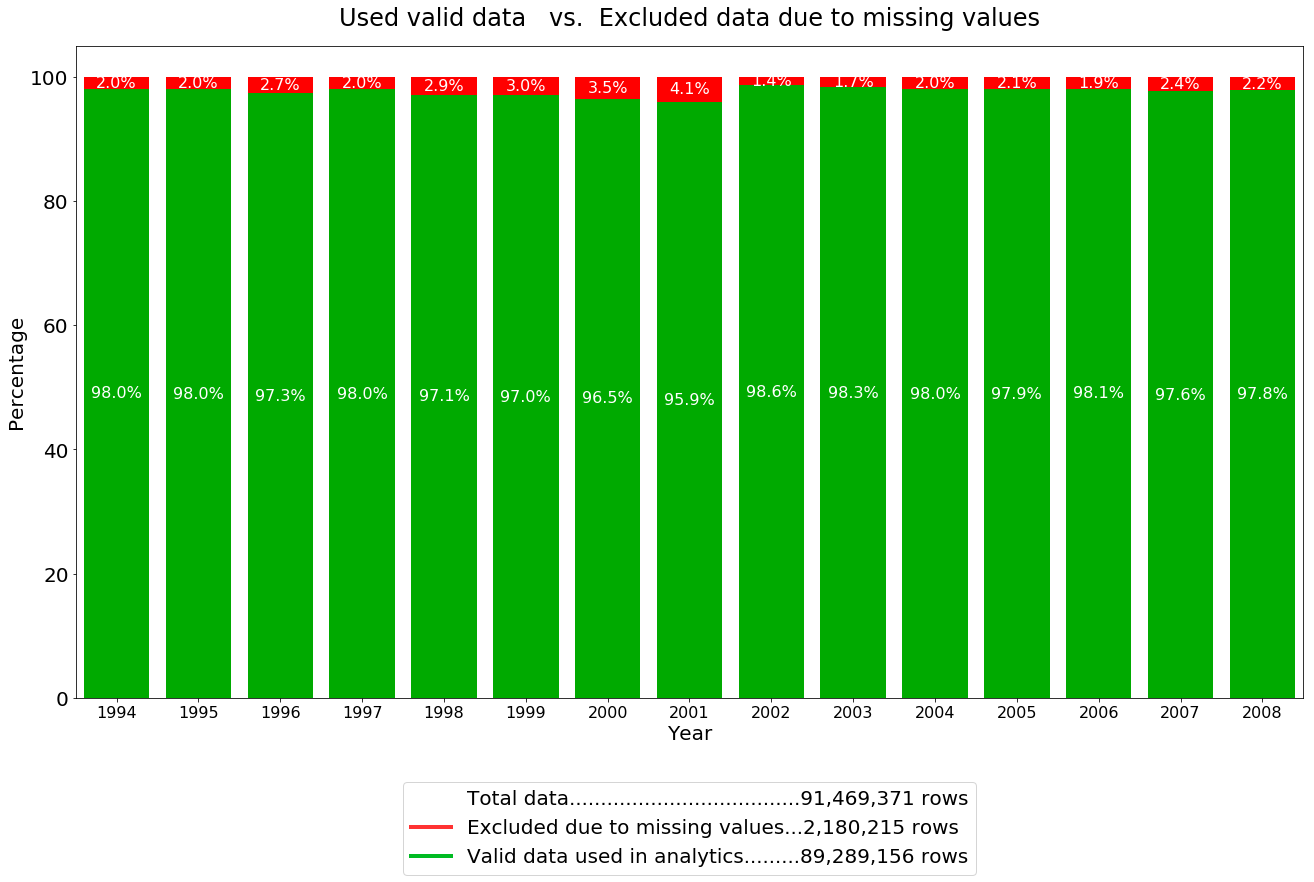

In [26]:
plot_missing_values_stacked_bar(df_missing)

The following chart show the percentage of dropped rows due to missing values.

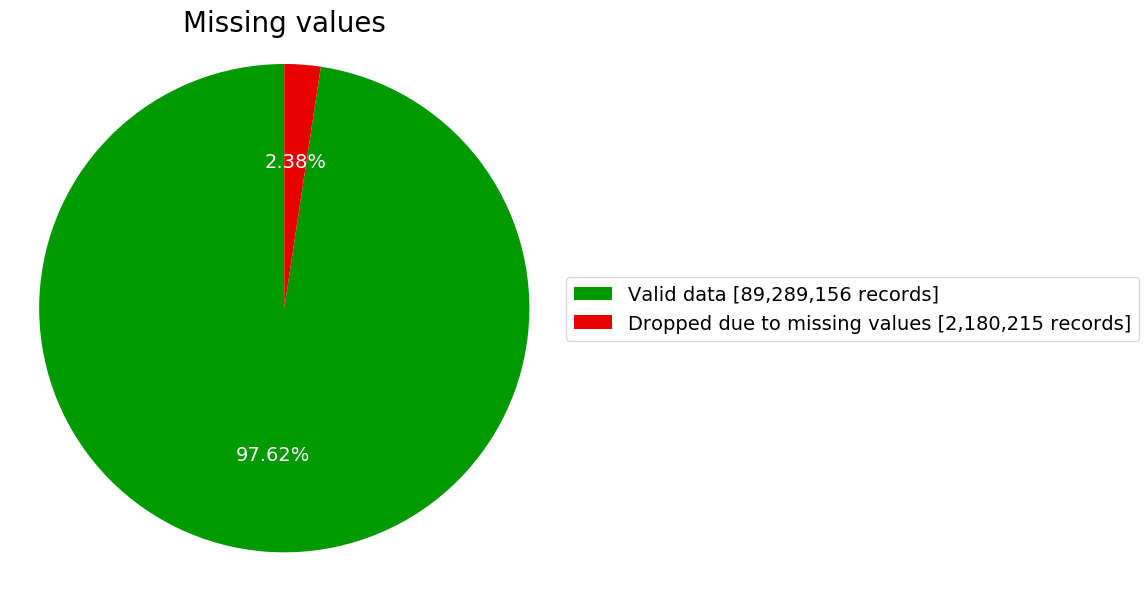

In [27]:
show_missing_pie_chart()

### Invalid group value

The following chart show the percentage of dropped rows due to group value exceeding the last valid group (13).

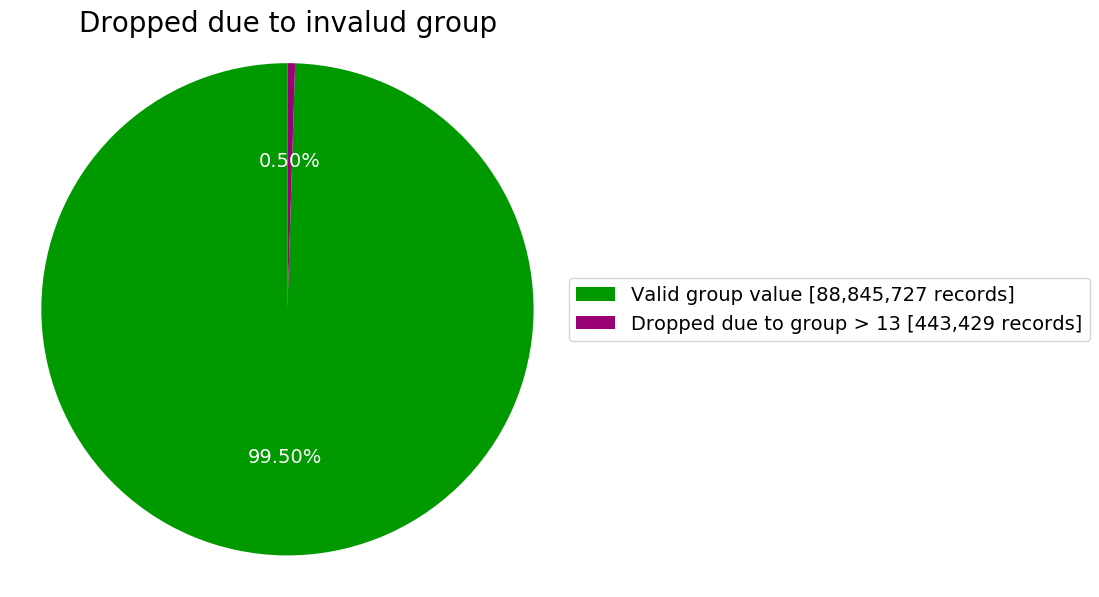

In [28]:
show_group_invalid_pie_chart()

### Summary of excluded data

The following chart show the summary of dropped rows

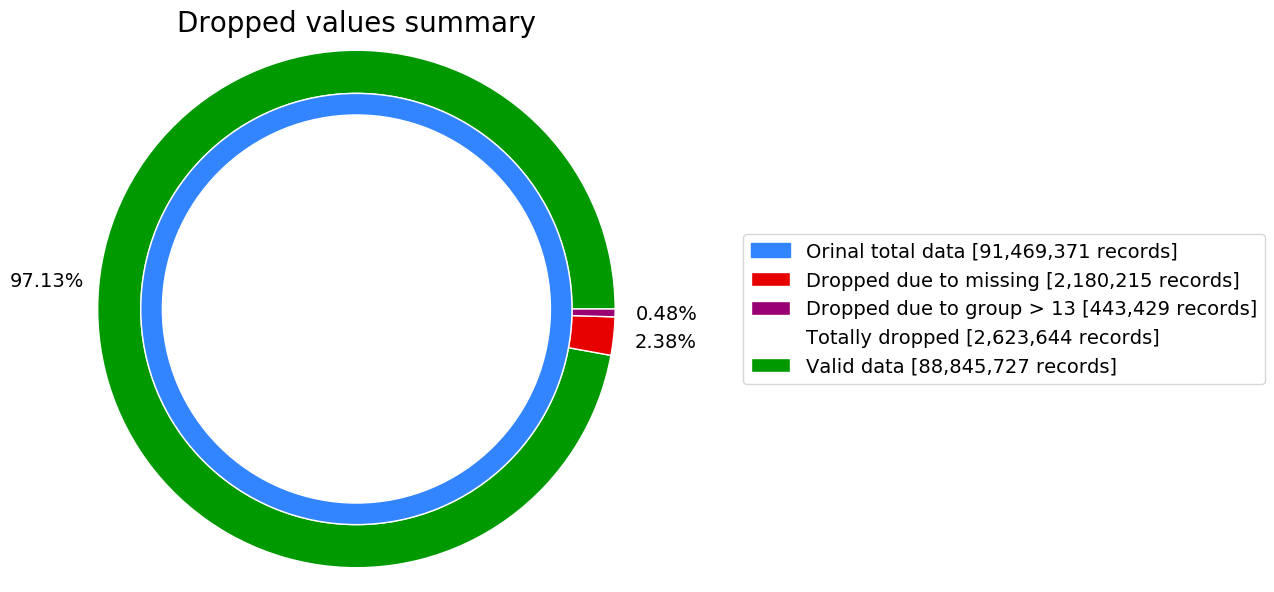

In [29]:
show_dropped_summary_pie_chart()

## Percentages of flights belonging to a distance group that halved a delay

### Delay per group

The following chart show the percentage of halved delay per group

In [30]:
def ui_callback(group):
    global halved_delays
    show_group_halved_delays_pie_chart(halved_delays[group])
    
groups_w = widgets.Dropdown(options=halved_delays.keys(), 
                                  value=list(halved_delays.keys())[0],
                                  description='Group')

ui = widgets.HBox([groups_w])    
out = widgets.interactive_output(ui_callback, {'group': groups_w})

display(ui, out)

Output()

## Comparison of halved delay percentages

The following stack bar chart compares the percentages of halved delay for all groups

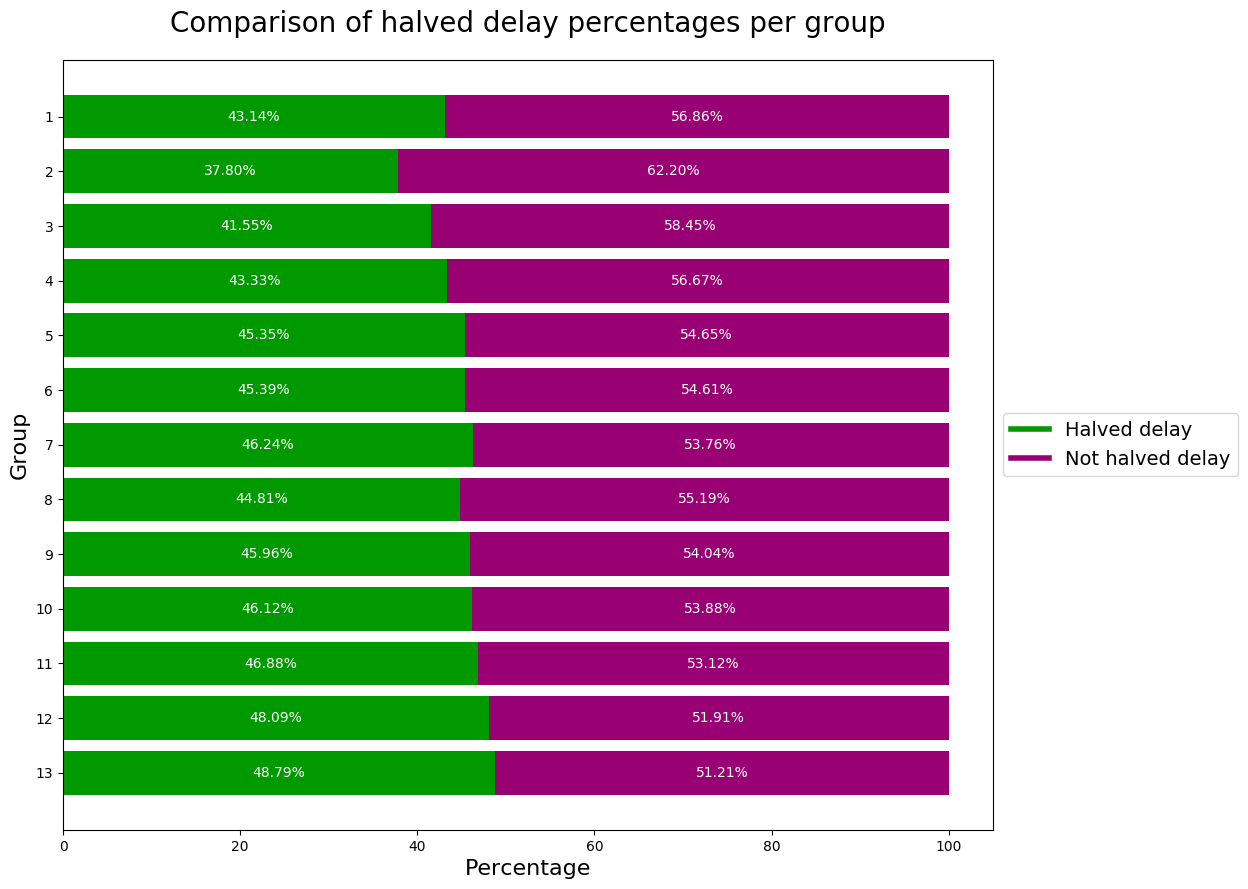

In [31]:
show_percetages_comparison_horizontal_stack_chart()